# Phân loại video cho trẻ em dựa trên title, madeForKids, tag, tỉ lệ like/dislike  sử dụng neural network

In [1]:
# Import các thư viện cần thiết!
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from underthesea import word_tokenize, sent_tokenize
from sklearn.pipeline import Pipeline

In [2]:
# Đọc dữ liệu từ file csv, xóa cột 'id', xóa các row thiếu dữ liệu và các cột trùng! 
from read_data import read_data
datapath = 'data/data_old.csv'
youtube_df = read_data(datapath)
youtube_df.info()
youtube_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4234 entries, 0 to 4233
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        4234 non-null   object
 1   tags         4234 non-null   object
 2   categoryID   4234 non-null   int64 
 3   madeForKids  4234 non-null   bool  
 4   Like         4234 non-null   int64 
 5   Dislike      4234 non-null   int64 
 6   Label        4234 non-null   int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 202.7+ KB


,title,tags,categoryID,madeForKids,Like,Dislike,Label
0,ABC Vui từng giờ | Tập 10: Chữ Ê | VTV7,#vtv7kids|#giaoduc|#treem|#thieunhi|#tieuhoc|#...,27,True,371,145,0
1,DÒNG SUỐI THẦN - PHIM HOẠT HÌNH - KHOẢNH KHẮC ...,quà tặng cuộc sống|quà tặng cuộc sống mới nhất...,1,False,398,60,0
2,Nghề Cảnh sát | Hướng nghiệp cho các bé | Lớn ...,hướng nghiệp|nghề|nghề nghiệp|bé|trẻ em|trẻ co...,27,True,414,198,0
3,Làm gì khi ngồi cạnh nhau nhưng chẳng nói một ...,Garena|garena liên quân|liên quân mobile|liên ...,20,False,415,15,2
4,World Tour - UK Part 1,Maroon5|UK|ColstonHall,10,False,430,190,1
5,Nghề Bác sĩ | Hướng nghiệp cho các bé | Lớn lê...,hướng nghiệp|nghề|nghề nghiệp|bé|trẻ em|trẻ co...,27,True,463,179,0
6,ABC Vui từng giờ | Tập 5: Chữ Ă | VTV7,#vtv7kids|#giaoduc|#treem|#thieunhi|#tieuhoc|#...,27,True,467,209,0
7,HỐ VÀNG HỐ BẠC - Truyện cổ tích - Chuyen co ti...,truyện cổ tích|cổ tích|truyện cổ tích việt nam...,1,False,495,95,0
8,THẾ GIỚI ĐỘNG VẬT - Truyện cổ tích - Chuyen co...,truyện cổ tích|cổ tích|truyện cổ tích việt nam...,1,False,509,130,0
9,Nghề Giáo viên | Hướng nghiệp cho các bé | Lớn...,hướng nghiệp|nghề|nghề nghiệp|bé|trẻ em|trẻ co...,27,True,539,216,0


In [3]:
df = youtube_df.groupby('Label').count()
df.head()

,title,tags,categoryID,madeForKids,Like,Dislike
Label,,,,,,
0,1589,1589,1589,1589,1589,1589
1,656,656,656,656,656,656
2,1989,1989,1989,1989,1989,1989


## Làm sạch dữ liệu phần title

In [4]:
# phân tách các tiêu đề video thành các cụm từ (sử dụng thư viện underthesea)
# Làm sạch dữ liệu phần title
from title import standardize_data
youtube_df['title'] = youtube_df['title'].apply(standardize_data)
youtube_df.info()
youtube_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4234 entries, 0 to 4233
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        4234 non-null   object
 1   tags         4234 non-null   object
 2   categoryID   4234 non-null   int64 
 3   madeForKids  4234 non-null   bool  
 4   Like         4234 non-null   int64 
 5   Dislike      4234 non-null   int64 
 6   Label        4234 non-null   int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 202.7+ KB


,title,tags,categoryID,madeForKids,Like,Dislike,Label
0,abc vui từng giờ tập 10 chữ ê vtv7,#vtv7kids|#giaoduc|#treem|#thieunhi|#tieuhoc|#...,27,True,371,145,0
1,dòng suối_thần phim_hoạt_hình khoảnh_khắc kỳ_d...,quà tặng cuộc sống|quà tặng cuộc sống mới nhất...,1,False,398,60,0
2,nghề cảnh_sát hướng_nghiệp cho các bé lớn lên ...,hướng nghiệp|nghề|nghề nghiệp|bé|trẻ em|trẻ co...,27,True,414,198,0
3,làm gì khi ngồi cạnh nhau nhưng chẳng nói một ...,Garena|garena liên quân|liên quân mobile|liên ...,20,False,415,15,2
4,world_tour uk_part 1,Maroon5|UK|ColstonHall,10,False,430,190,1
5,nghề bác_sĩ hướng_nghiệp cho các bé lớn lên em...,hướng nghiệp|nghề|nghề nghiệp|bé|trẻ em|trẻ co...,27,True,463,179,0
6,abc vui từng giờ tập 5 chữ ă vtv7,#vtv7kids|#giaoduc|#treem|#thieunhi|#tieuhoc|#...,27,True,467,209,0
7,hố vàng hố_bạc truyện_cổ_tích chuyen co tich p...,truyện cổ tích|cổ tích|truyện cổ tích việt nam...,1,False,495,95,0
8,thế_giới động_vật truyện_cổ_tích chuyen co tic...,truyện cổ tích|cổ tích|truyện cổ tích việt nam...,1,False,509,130,0
9,nghề giáo_viên hướng_nghiệp cho các bé lớn lên...,hướng nghiệp|nghề|nghề nghiệp|bé|trẻ em|trẻ co...,27,True,539,216,0


In [5]:
# Xóa đi các hàng bị rỗng sau khi làm sạch dữ liệu phần title
youtube_df['title'].replace('', np.nan, inplace=True)
youtube_df = youtube_df.dropna()
youtube_df = youtube_df.drop_duplicates()
youtube_df = youtube_df.reset_index(drop=True)
youtube_df.info()
youtube_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4231 entries, 0 to 4230
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        4231 non-null   object
 1   tags         4231 non-null   object
 2   categoryID   4231 non-null   int64 
 3   madeForKids  4231 non-null   bool  
 4   Like         4231 non-null   int64 
 5   Dislike      4231 non-null   int64 
 6   Label        4231 non-null   int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 202.6+ KB


,title,tags,categoryID,madeForKids,Like,Dislike,Label
0,abc vui từng giờ tập 10 chữ ê vtv7,#vtv7kids|#giaoduc|#treem|#thieunhi|#tieuhoc|#...,27,True,371,145,0
1,dòng suối_thần phim_hoạt_hình khoảnh_khắc kỳ_d...,quà tặng cuộc sống|quà tặng cuộc sống mới nhất...,1,False,398,60,0
2,nghề cảnh_sát hướng_nghiệp cho các bé lớn lên ...,hướng nghiệp|nghề|nghề nghiệp|bé|trẻ em|trẻ co...,27,True,414,198,0
3,làm gì khi ngồi cạnh nhau nhưng chẳng nói một ...,Garena|garena liên quân|liên quân mobile|liên ...,20,False,415,15,2
4,world_tour uk_part 1,Maroon5|UK|ColstonHall,10,False,430,190,1


## Chuyển dữ liệu title về dạng ma trận bằng tfidf

In [6]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

with open("data/vietnamese-stopwords.txt", encoding='utf-8') as f:
    stopwords = f.readlines()
stopwords = [x.strip().replace(" ", "_") for x in stopwords]

module_count_vector = CountVectorizer(stop_words = stopwords)
model_rf_preprocess = Pipeline([('vect', module_count_vector),
                    ('tfidf', TfidfTransformer()),
                    ])
data_preprocessed = model_rf_preprocess.fit_transform(youtube_df['title'].values)                           
title_df_tfidf = pd.DataFrame(data_preprocessed.todense(), columns=module_count_vector.get_feature_names())
print('Độ dài tập từ điển: ')
print(len(module_count_vector.get_feature_names()))
title_df_tfidf.head()

Độ dài tập từ điển: 
7967


,006,01,011,0175,02,021,03,04,05,05072018,...,ốm,ống,ống_tiêm,ốp,ổ_khóa,ổi,ổn,ở_ẩn,ủng_hộ,ứng_xử
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Chuyển tag về dạng ma trận xuất hiện

In [7]:
# Tạo DataFrame mới(xóa cột title)
non_title_df = youtube_df.copy()
if 'title' in non_title_df.columns:
    non_title_df = non_title_df.drop(['title'], axis = 1)
non_title_df.info()
non_title_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4231 entries, 0 to 4230
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tags         4231 non-null   object
 1   categoryID   4231 non-null   int64 
 2   madeForKids  4231 non-null   bool  
 3   Like         4231 non-null   int64 
 4   Dislike      4231 non-null   int64 
 5   Label        4231 non-null   int64 
dtypes: bool(1), int64(4), object(1)
memory usage: 169.5+ KB


,tags,categoryID,madeForKids,Like,Dislike,Label
0,#vtv7kids|#giaoduc|#treem|#thieunhi|#tieuhoc|#...,27,True,371,145,0
1,quà tặng cuộc sống|quà tặng cuộc sống mới nhất...,1,False,398,60,0
2,hướng nghiệp|nghề|nghề nghiệp|bé|trẻ em|trẻ co...,27,True,414,198,0
3,Garena|garena liên quân|liên quân mobile|liên ...,20,False,415,15,2
4,Maroon5|UK|ColstonHall,10,False,430,190,1


In [8]:
# Xóa các kí tự đặc biệt (#, ") khỏi cột tags
from non_title import standardize_tags
non_title_df = standardize_tags(non_title_df)
non_title_df.info()
non_title_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4231 entries, 0 to 4230
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   tags         4231 non-null   object 
 1   categoryID   4231 non-null   int64  
 2   madeForKids  4231 non-null   int64  
 3   Label        4231 non-null   int64  
 4   rate         4231 non-null   float64
dtypes: float64(1), int64(3), object(1)
memory usage: 165.4+ KB


,tags,categoryID,madeForKids,Label,rate
0,vtv7kids|giaoduc|treem|thieunhi|tieuhoc|mamnon...,27,1,0,0.718992
1,quà tặng cuộc sống|quà tặng cuộc sống mới nhất...,1,0,0,0.868996
2,hướng nghiệp|nghề|nghề nghiệp|bé|trẻ em|trẻ co...,27,1,0,0.676471
3,Garena|garena liên quân|liên quân mobile|liên ...,20,0,2,0.965116
4,Maroon5|UK|ColstonHall,10,0,1,0.693548


In [9]:
# split tag
from non_title import get_clean_tags

clean_tags = get_clean_tags(non_title_df['tags'])
print("Số lượng tag: " + str(len(clean_tags)))
print(clean_tags[:5])

Số lượng tag: 4231
[['vtv7kids', 'giaoduc', 'treem', 'thieunhi', 'tieuhoc', 'mamnon', 'abc vui tung gio', 'english for kids', 'english', 'bang chu cai', 'bang chu cai cho be', 'tieng anh tre em', 'hoc bang chu cai', 'danh van tre em', 'hoc danh van'], ['quà tặng cuộc sống', 'quà tặng cuộc sống mới nhất', 'quà tặng cuộc sống tổng hợp', 'phim quà tặng cuộc sống', 'qtcs', 'qtcs 2020', 'hoat hinh', 'phim hoạt hình', 'hoạt hình hay', 'sự tích', 'truyện cổ tích', 'chuyện cổ tích', 'kkkd', 'phim ngắn', 'tổng hợp phim', 'bài học cuộc sống', 'câu chuyện ý nghĩa', 'giây phút diệu kỳ', 'câu chuyện cuộc sống', 'khoảnh khắc kỳ diệu', 'dòng suối thần', 'suối thần', 'thần', 'dòng suối thanh xuân', 'phim hoạt hình dòng suối thần'], ['hướng nghiệp', 'nghề', 'nghề nghiệp', 'bé', 'trẻ em', 'trẻ con', 'mẫu giáo', 'cấp 1', 'tiểu học', 'bác sĩ', 'công an', 'cảnh sát', 'phi công', 'nông dân', 'xây dựng', 'lính', 'lính cứu hỏa', 'đầu bếp', 'họa sĩ', 'giáo viên', 'cầu thủ', 'bóng đá', 'kỹ năng', 'đồng phục', '

In [10]:
# Tính tần suất xuất hiện của tất cả các tag
from non_title import get_tags_frequency

tag_frequency = get_tags_frequency(non_title_df['tags'])
print('số lượng tags khác nhau: ' + str(len(tag_frequency)))
tag_frequency

số lượng tags khác nhau: 34269


{'vtv7kids': 6,
 'giaoduc': 6,
 'treem': 6,
 'thieunhi': 7,
 'tieuhoc': 6,
 'mamnon': 6,
 'abc vui tung gio': 1,
 'english for kids': 2,
 'english': 10,
 'bang chu cai': 4,
 'bang chu cai cho be': 0,
 'tieng anh tre em': 3,
 'hoc bang chu cai': 0,
 'danh van tre em': 1,
 'hoc danh van': 0,
 'quà tặng cuộc sống': 64,
 'quà tặng cuộc sống mới nhất': 53,
 'quà tặng cuộc sống tổng hợp': 53,
 'phim quà tặng cuộc sống': 53,
 'qtcs': 53,
 'qtcs 2020': 53,
 'hoat hinh': 81,
 'phim hoạt hình': 104,
 'hoạt hình hay': 66,
 'sự tích': 55,
 'truyện cổ tích': 99,
 'chuyện cổ tích': 79,
 'kkkd': 53,
 'phim ngắn': 62,
 'tổng hợp phim': 53,
 'bài học cuộc sống': 56,
 'câu chuyện ý nghĩa': 53,
 'giây phút diệu kỳ': 53,
 'câu chuyện cuộc sống': 53,
 'khoảnh khắc kỳ diệu': 72,
 'dòng suối thần': 0,
 'suối thần': 0,
 'thần': 4,
 'dòng suối thanh xuân': 0,
 'phim hoạt hình dòng suối thần': 0,
 'hướng nghiệp': 2,
 'nghề': 3,
 'nghề nghiệp': 2,
 'bé': 7,
 'trẻ em': 51,
 'trẻ con': 5,
 'mẫu giáo': 4,
 'cấp 1':

In [11]:
# Lọc ra những tag có tần số xuất hiện >= 6
from non_title import get_tags_vocab

pruned_vocab = get_tags_vocab(tag_frequency, 5)
print(len(pruned_vocab))

2169


In [12]:
# Chuẩn hóa dữ liệu các cột categoryId, madeForKids và rate
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

non_title_scaler_df = non_title_df.copy()
non_title_scaler_df[['categoryID', 'madeForKids', 'rate']] = scaler.fit_transform(non_title_df[['categoryID', 'madeForKids', 'rate']])
non_title_scaler_df.info()
non_title_scaler_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4231 entries, 0 to 4230
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   tags         4231 non-null   object 
 1   categoryID   4231 non-null   float64
 2   madeForKids  4231 non-null   float64
 3   Label        4231 non-null   int64  
 4   rate         4231 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 165.4+ KB


,tags,categoryID,madeForKids,Label,rate
0,vtv7kids|giaoduc|treem|thieunhi|tieuhoc|mamnon...,0.846329,1.782331,0,-1.018668
1,quà tặng cuộc sống|quà tặng cuộc sống mới nhất...,-2.308470,-0.561063,0,0.101618
2,hướng nghiệp|nghề|nghề nghiệp|bé|trẻ em|trẻ co...,0.846329,1.782331,0,-1.336237
3,Garena|garena liên quân|liên quân mobile|liên ...,-0.003040,-0.561063,2,0.819485
4,Maroon5|UK|ColstonHall,-1.216424,-0.561063,1,-1.208693


In [13]:
# Tìm số lượng tag lớn nhất của video
max_of_tags = 0;
for tag in clean_tags:
    max_of_tags = max(max_of_tags, len(tag))
print("Số lượng tag lớn nhất của 1 video:", max_of_tags)

Số lượng tag lớn nhất của 1 video: 78


In [14]:
# Tạo ma trận với các tag được split ra
from dataframe_creator import create_new_columns

non_title_new_df = create_new_columns(non_title_scaler_df, max_of_tags, 'tags')
non_title_new_df.info()
non_title_new_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4231 entries, 0 to 4230
Data columns (total 82 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   categoryID   4231 non-null   float64
 1   madeForKids  4231 non-null   float64
 2   Label        4231 non-null   int64  
 3   rate         4231 non-null   float64
 4   tag_0        4231 non-null   object 
 5   tag_1        4231 non-null   object 
 6   tag_2        4231 non-null   object 
 7   tag_3        4231 non-null   object 
 8   tag_4        4231 non-null   object 
 9   tag_5        4231 non-null   object 
 10  tag_6        4231 non-null   object 
 11  tag_7        4231 non-null   object 
 12  tag_8        4231 non-null   object 
 13  tag_9        4231 non-null   object 
 14  tag_10       4231 non-null   object 
 15  tag_11       4231 non-null   object 
 16  tag_12       4231 non-null   object 
 17  tag_13       4231 non-null   object 
 18  tag_14       4231 non-null   object 
 19  tag_15

,categoryID,madeForKids,Label,rate,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,...,tag_68,tag_69,tag_70,tag_71,tag_72,tag_73,tag_74,tag_75,tag_76,tag_77
0,0.846329,1.782331,0,-1.018668,vtv7kids,giaoduc,treem,thieunhi,tieuhoc,mamnon,...,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
1,-2.308470,-0.561063,0,0.101618,quà tặng cuộc sống,quà tặng cuộc sống mới nhất,quà tặng cuộc sống tổng hợp,phim quà tặng cuộc sống,qtcs,qtcs 2020,...,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
2,0.846329,1.782331,0,-1.336237,hướng nghiệp,nghề,nghề nghiệp,bé,trẻ em,trẻ con,...,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
3,-0.003040,-0.561063,2,0.819485,Garena,garena liên quân,liên quân mobile,liên quân,arena of valor,AOV,...,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
4,-1.216424,-0.561063,1,-1.208693,Maroon5,UK,ColstonHall,notags,notags,notags,...,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags


In [15]:
# Tạo ma trận xuất hiện của các từ khóa có tần suất xuất hiện >= 3 (ở bước trước)
from dataframe_creator import create_matrix_pruned_tags

matrix_pruned_tags = create_matrix_pruned_tags(non_title_new_df, ['categoryID', 'madeForKids', 'Label', 'rate'], pruned_vocab)
matrix_pruned_tags.info()
matrix_pruned_tags.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4231 entries, 0 to 4230
Columns: 2173 entries, categoryID to Nhạc chế hậu hoàng
dtypes: float64(2172), int64(1)
memory usage: 70.1 MB


,categoryID,madeForKids,Label,rate,vtv7kids,giaoduc,treem,thieunhi,tieuhoc,mamnon,...,hậu hoàng mới nhất,FAPtivi,cơm nguội,Ribi Sachi,Thai Vu,hai moi 2015,ba tan hài hước,ribi,hau hoang 2020,Nhạc chế hậu hoàng
0,0.846329,1.782331,0,-1.018668,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-2.308470,-0.561063,0,0.101618,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.846329,1.782331,0,-1.336237,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.003040,-0.561063,2,0.819485,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.216424,-0.561063,1,-1.208693,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Merge 2 ma trận title và tags lại với nhau

In [16]:
youtube_df_final = title_df_tfidf.merge(matrix_pruned_tags, left_index=True, right_index=True, how='left')
youtube_df_final.info()
youtube_df_final.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4231 entries, 0 to 4230
Columns: 10140 entries, 006 to Nhạc chế hậu hoàng
dtypes: float64(10139), int64(1)
memory usage: 327.3 MB


,006,01,011,0175,02,021,03,04,05,05072018,...,hậu hoàng mới nhất,FAPtivi,cơm nguội,Ribi Sachi,Thai Vu,hai moi 2015,ba tan hài hước,ribi,hau hoang 2020,Nhạc chế hậu hoàng
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Training model

In [17]:
# Chia dữ liệu thành 3 tập
from input_generator import generate_dataset
(train_ds, train_lb), (val_ds, val_lb), (test_ds, test_lb) = generate_dataset(youtube_df_final, 'Label')
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

2538
846
847


In [18]:
from tensorflow.keras.regularizers import l2


model = tf.keras.Sequential([
    layers.Dense(300, kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001), activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(500,kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001), activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(500,kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001) , activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(100,kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001), activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(12,kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001), activation='softmax')])

nadam = keras.optimizers.Nadam(lr=0.00001)

model.compile(optimizer=nadam,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              )

history = model.fit(train_ds.values, train_lb.values,
                    batch_size=32,
                    epochs=70,
                    validation_data=(val_ds.values, val_lb.values))

Epoch 1/70
80/80 [==============================] - 9s 108ms/step - loss: 3.1074 - accuracy: 0.1072 - val_loss: 3.0850 - val_accuracy: 0.4125
Epoch 2/70
80/80 [==============================] - 10s 120ms/step - loss: 3.0599 - accuracy: 0.2829 - val_loss: 3.0425 - val_accuracy: 0.4894
Epoch 3/70
80/80 [==============================] - 8s 99ms/step - loss: 3.0037 - accuracy: 0.4184 - val_loss: 2.9868 - val_accuracy: 0.5378
Epoch 4/70
80/80 [==============================] - 8s 96ms/step - loss: 2.9336 - accuracy: 0.4744 - val_loss: 2.9057 - val_accuracy: 0.5331
Epoch 5/70
80/80 [==============================] - 8s 102ms/step - loss: 2.8265 - accuracy: 0.5016 - val_loss: 2.7828 - val_accuracy: 0.5248
Epoch 6/70
80/80 [==============================] - 7s 93ms/step - loss: 2.6656 - accuracy: 0.5138 - val_loss: 2.6008 - val_accuracy: 0.5284
Epoch 7/70
80/80 [==============================] - 7s 89ms/step - loss: 2.4656 - accuracy: 0.5331 - val_loss: 2.3599 - val_accuracy: 0.5579
Epoch 8/7

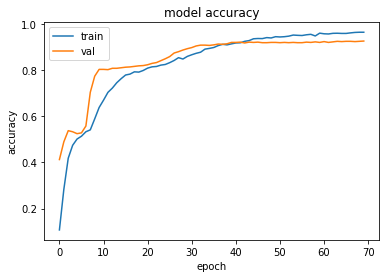

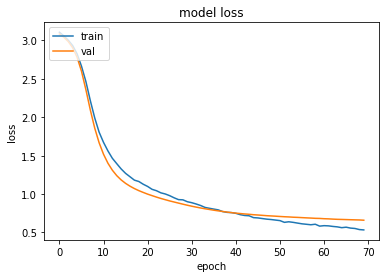

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plt.plot(acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Trực quan dữ liệu mất
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
results = model.evaluate(test_ds, test_lb)

print(results)

27/27 [==============================] - 0s 12ms/step - loss: 0.6659 - accuracy: 0.9150
[0.6658591032028198, 0.9149941205978394]


In [21]:
from sklearn.metrics import classification_report

predictions = model.predict(test_ds.values)
print(classification_report(test_lb.values, np.argmax(predictions, axis=1)))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       323
           1       0.85      0.67      0.75       147
           2       0.90      0.96      0.93       377

    accuracy                           0.91       847
   macro avg       0.90      0.87      0.88       847
weighted avg       0.91      0.91      0.91       847



# Thử nghiệm trên dữ liệu mới

In [123]:
# transform title
title = 'CẢM XÚC CỦA VIRUSS KHI XEM CHẠY NGAY ĐI (ONIONN REMIX) | RUN NOW | SƠN TÙNG M-TP | VIRUSS REACTION'
title = standardize_data(title)
print(title)
title_new_tfidf = model_rf_preprocess.transform([title])
title_new_df_tfidf = pd.DataFrame(title_new_tfidf.todense(), columns=module_count_vector.get_feature_names())

print(title_new_df_tfidf)

s8 tuyển_tập hoạt_hình doraemon_phần 88 doraemon trong ngày_yêu không được phản_bội vua nobita
   006   01  011  0175   02  021   03   04   05  05072018  ...   ốm  ống  \
0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0       0.0  ...  0.0  0.0   

   ống_tiêm   ốp  ổ_khóa   ổi   ổn  ở_ẩn  ủng_hộ  ứng_xử  
0       0.0  0.0     0.0  0.0  0.0   0.0     0.0     0.0  

[1 rows x 7967 columns]


In [136]:
# transform các thông tin còn lại
tags =  'viruss|cảm xúc của viruss|viruss reaction|cảm xúc của viruss khi xem|viruss reaction chạy ngay đi|cảm xúc của viruss khi xem chạy ngay đi|cảm xúc của viruss khi xem chạy ngay đi remix|viruss reaction chạy ngay đi remix|reaction chạy ngay đi remix|chạy ngay đi remix reaction|onionn remix|chạy ngay đi remix|chay ngay di remix|run now reaction|run now|run now remix|chạy ngay đi|chạy ngay đi sơn tùng mtp|chạy ngay đi onionn remix|chạy ngay đi remix sơn tùng|mtp'
categoryId = 20
madeForKids = 0 
Label = 0
Like = 44544
Dislike = 882
rate = Like/(Like + Dislike)

non_title_test_df = pd.DataFrame([[tags, categoryId, madeForKids, Label, rate]], columns = ['tags', 'categoryID', 'madeForKids','Label', 'rate'])
non_title_test_df = standardize_tags(non_title_test_df)
non_title_test_scaler_df = non_title_test_df.copy()


new_scaler = StandardScaler()
new_scaler.fit(non_title_df[['categoryID', 'madeForKids', 'rate']])
non_title_test_scaler_df[['categoryID', 'madeForKids', 'rate']] = new_scaler.transform(non_title_test_df[['categoryID', 'madeForKids', 'rate']])

new = tags.split('|')
cot_khong_dung = ['categoryID', 'madeForKids','Label', 'rate']

matrix_pruned_new_list = []
matrix_pruned_new_list.append(non_title_test_scaler_df['categoryID'][0])
matrix_pruned_new_list.append(non_title_test_scaler_df['madeForKids'][0])
matrix_pruned_new_list.append(non_title_test_scaler_df['rate'][0])

for col in matrix_pruned_tags.columns:
    if col not in cot_khong_dung:
        if col in new:
            matrix_pruned_new_list.append(1.0)
        else:
            matrix_pruned_new_list.append(0.0)
matrix_pruned_new = pd.DataFrame([matrix_pruned_new_list])

In [137]:
# merge lại với nhau
test_df = title_new_df_tfidf.merge(matrix_pruned_new, left_index=True, right_index=True, how='left')
if "Label" in test_df.columns:
    test_df = test_df.drop(['Label'], axis = 1)
test_df.head()

,006,01,011,0175,02,021,03,04,05,05072018,...,2162,2163,2164,2165,2166,2167,2168,2169,2170,2171
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [138]:
#Dự đoán kết quả.
rs = model.predict_classes(test_df)
print(rs)
if rs == 0:
    print('Phù hợp')
elif rs == 1:
    print('Trung gian')
else:
    print('Không phù hợp')

[1]
Trung gian


# Lưu model

In [112]:
model.save('model')

INFO:tensorflow:Assets written to: model\assets


In [113]:
import pickle
pickle.dump(model_rf_preprocess, open("model_rf_preprocess.pickle", "wb"))

In [114]:
import pickle
pickle.dump(module_count_vector, open("module_count_vector.pickle", "wb"))

In [115]:
non_title_df.to_csv(r'data/non_title_df.csv', index=False)

In [116]:
non_title_new_df.to_csv(r'data/non_title_new_df.csv', index = False)

In [117]:
import pickle
with open("data/pruned_vocab.txt", "wb") as fp:   #Pickling
    pickle.dump(pruned_vocab, fp)

In [139]:
matrix_pruned_tags.to_csv(r'data/matrix_pruned_tags.csv', index = False)